In [5]:
%load_ext autoreload
%autoreload 2

import os
import gc
import math
import pickle
import numpy as np
import pandas as pd
import scipy.sparse as sps
import scanpy as sc
import anndata as ad
import scipy.io as sio

from os.path import join
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
import gc

from sklearn.preprocessing import normalize
from sklearn.utils.extmath import randomized_svd

from ACE.ace import ACE
from ACE.utils import nn_approx
from ACE.preprocessing import lsiTransformer, ADTransformer, HARMONY

import sys
sys.path.insert(0, './')
from imp_evaluation import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## loading data

In [2]:
root_dir = '../../data/Multiome'
dataset_path = os.path.join(
    root_dir, 
    'openproblems_bmmc_multiome_phase2_rna.censor_dataset.output_'
)

par = {
    'input_train_mod1': f'{dataset_path}train_mod1.h5ad',
    'input_train_mod2': f'{dataset_path}train_mod2.h5ad',
    'input_train_sol': f'{dataset_path}train_sol.h5ad',
    'input_test_sol': f'{dataset_path}test_sol.h5ad',
    'input_test_mod1': f'{dataset_path}test_mod1.h5ad',
    'input_test_mod2': f'{dataset_path}test_mod2.h5ad',
}

print('Reading `h5ad` files...')
input_train_mod1 = sc.read_h5ad(par['input_train_mod1'])
input_train_mod2 = sc.read_h5ad(par['input_train_mod2'])
input_train_sol = sc.read_h5ad(par['input_train_sol'])
input_test_mod1 = sc.read_h5ad(par['input_test_mod1'])
input_test_mod2 = sc.read_h5ad(par['input_test_mod2'])

print("Unscrambling training cells...")
ord = input_train_sol.X.tocsr().indices
if "pairing_ix" in input_train_sol.uns:
    assert np.all(ord == np.argsort(input_train_sol.uns["pairing_ix"]))
input_train_mod2 = input_train_mod2[ord, :].copy()
input_train_mod2.obs_names = input_train_mod1.obs_names

input_test_sol = sc.read_h5ad(par['input_test_sol'])
ord = input_test_sol.X.tocsr().indices
if "pairing_ix" in input_test_sol.uns:
    assert np.all(ord == np.argsort(input_test_sol.uns["pairing_ix"]))
input_test_mod2 = input_test_mod2[ord, :].copy()
input_test_mod2.obs_names = input_test_mod1.obs_names   

hvp_idx = np.argsort(input_train_mod2.X.sum(axis=0).A1)[-30000:]
input_train_mod2 = input_train_mod2[:, hvp_idx].copy()
input_test_mod2  = input_test_mod2[:, hvp_idx].copy()

# select hvg for evaluation
sc.pp.highly_variable_genes(input_train_mod1, n_top_genes=5000)
hvg_idx = np.where(input_train_mod1.var.highly_variable)[0]

Reading `h5ad` files...


/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/anndata/_io/specs/registry.py:235: OldFormatWarning: Element '/layers' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=get_spec(elem))
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/anndata/_io/utils.py:202: OldFormatWarning: Element '/obs/__categories/batch' was written without encoding metadata.
  return func(*args, **kwargs)
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/anndata/_io/utils.py:202: OldFormatWarning: Element '/obs/batch' was written without encoding metadata.
  return func(*args, **kwargs)
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/anndata/_io/utils.py:202: OldFormatWarning: Element '/obs/size_factors' was written without encoding metadata.
  return func(*args, **kwargs)
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/anndata/_io/utils.py:202: OldFormatWarning: Element '/obs/_index' was w

Unscrambling training cells...


/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/anndata/_io/utils.py:202: OldFormatWarning: Element '/obs/__categories/batch' was written without encoding metadata.
  return func(*args, **kwargs)
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/anndata/_io/utils.py:202: OldFormatWarning: Element '/obs/batch' was written without encoding metadata.
  return func(*args, **kwargs)
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/anndata/_io/utils.py:202: OldFormatWarning: Element '/obs/_index' was written without encoding metadata.
  return func(*args, **kwargs)
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/anndata/_io/specs/registry.py:235: OldFormatWarning: Element '/uns' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=get_spec(elem))
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/anndata/_io/specs/registry.py:235: OldFormatWarning: Element '/uns/dataset_id' w

In [3]:
log_dir = '../../outputs/Multiome-imp'

## RNA->ATAC

In [6]:
os.makedirs(join(log_dir, 'RNA2ATAC'), exist_ok=True)
gex = input_train_mod1.copy()
other = input_train_mod2.copy()
gex_test = input_test_mod1.copy()
other_test = input_test_mod2.copy()

#### preprocessing
if not os.path.exists(join(log_dir, 'RNA2ATAC/gex_train_input.npy')):
    ### GEX preprocessing
    gex_all = sc.concat([gex, gex_test])
    lsi_former = lsiTransformer(192, drop_first=True, use_highly_variable=False, log=False, norm=False, 
                                z_score=True, tfidf=False, svd=True, use_counts=False
    )
    gex_all_lsi_df = lsi_former.fit_transform(gex_all)
    gex_all_dimred = HARMONY(gex_all_lsi_df, gex_all.obs.batch.to_list(), use_gpu=True)
    gex.obsm['dimred_be'], gex_test.obsm['dimred_be'] = gex_all_dimred[:gex.shape[0]], gex_all_dimred[gex.shape[0]:]

    del gex_all, gex_all_lsi_df, gex_all_dimred
    gc.collect()

    # ATAC processing
    atac_lsi_former = lsiTransformer(192, drop_first=True, use_highly_variable=False, log=False, norm=False, 
                                z_score=True, tfidf=False, svd=True, 
    )
    atac_df = atac_lsi_former.fit_transform(other)
    other.obsm['dimred_be'] = HARMONY(atac_df, other.obs.batch.to_list(), use_gpu=True)
    other_test.obsm['dimred_be'] = np.zeros((other_test.shape[0], 192))

    del atac_df

    np.save(join(log_dir, 'RNA2ATAC/gex_train_input.npy'), gex.obsm['dimred_be'])
    np.save(join(log_dir, 'RNA2ATAC/gex_test_input.npy'),  gex_test.obsm['dimred_be'])
    np.save(join(log_dir, 'RNA2ATAC/other_train_input.npy'), other.obsm['dimred_be'])

else:
    gex.obsm['dimred_be']      = np.load(join(log_dir, 'RNA2ATAC/gex_train_input.npy'))
    gex_test.obsm['dimred_be'] = np.load(join(log_dir, 'RNA2ATAC/gex_test_input.npy'))
    other.obsm['dimred_be']     = np.load(join(log_dir, 'RNA2ATAC/other_train_input.npy'))   
    other_test.obsm['dimred_be']= np.zeros((other_test.shape[0], 192))

Use GPU mode.
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
Reach convergence after 3 iteration(s).
Use GPU mode.
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
Reach convergence after 2 iteration(s).


In [7]:
n_parts = 2
modBatch_dict = {
    'rna': [gex, gex_test],
    'atac': [other, None]
}

useReps_dict = {
    'rna': 'dimred_be',
    'atac': 'dimred_be'
}

In [8]:
# building stage 1
T = 0.1
model = ACE(
    modBatch_dict=modBatch_dict,  
    useReps_dict=useReps_dict,  
    batch_key='batch', 
    layers_dims = {'rna': [1024, 512], 'atac':[1024, 512]}, # consistent across all experiments
    dropout_rates = {'rna':[0.2, 0.2], 'atac':[0.2, 0.2]},  # consistent across all experiments
    T=math.log(1./T), T_learnable=False, log_dir=join(log_dir, 'RNA2ATAC'),
    n_latent1=40, n_latent2=256, seed=1234, num_workers=0
)

model.stage1_fit(
    batch_size=512,
    epochs=100,
    lr=2e-4, 
    log_step=10, 
)

batch0: ['rna', 'atac']
batch1: ['rna']
Batch ids used in training:  [0]
Training stage1
Epoch 9, loss=4.0556, temp=10.0000, batch0 loss=4.0556, 
Epoch 19, loss=3.9275, temp=10.0000, batch0 loss=3.9275, 
Epoch 29, loss=3.8071, temp=10.0000, batch0 loss=3.8071, 
Epoch 39, loss=3.7058, temp=10.0000, batch0 loss=3.7058, 
Epoch 49, loss=3.6222, temp=10.0000, batch0 loss=3.6222, 
Epoch 59, loss=3.5530, temp=10.0000, batch0 loss=3.5530, 
Epoch 69, loss=3.4859, temp=10.0000, batch0 loss=3.4859, 
Epoch 79, loss=3.4257, temp=10.0000, batch0 loss=3.4257, 
Epoch 89, loss=3.3731, temp=10.0000, batch0 loss=3.3731, 
Epoch 99, loss=3.3180, temp=10.0000, batch0 loss=3.3180, 


In [9]:
# stage1 inference
ad_integ = model.stage1_infer(
    modBatch_dict, useReps_dict, output_key='stage1_emb', 
    specify_mods_perBatch=[['rna'], ['rna']]
)
ad_integ

AnnData object with n_obs × n_vars = 62501 × 40
    obs: 'batch', 'size_factors', 'raw_batch', 'domain'

In [11]:
# impute
imputed_data = model.impute(modBatch_dict, output_key1='stage1_emb', knn=20, verbose=True)
Y_hat = imputed_data['atac'][1]

batch 0: no need for imputation
batch 1: impute => ['atac']


## ATAC -> RNA

In [12]:
os.makedirs(join(log_dir, 'ATAC2RNA'), exist_ok=True)
gex = input_train_mod1.copy()
other = input_train_mod2.copy()
gex_test = input_test_mod1.copy()
other_test = input_test_mod2.copy()

#### preprocessing
if not os.path.exists(join(log_dir, 'ATAC2RNA/gex_train_input.npy')):
    ### GEX preprocessing
    lsi_former = lsiTransformer(192, drop_first=True, use_highly_variable=False, log=False, norm=False, 
                                z_score=True, tfidf=False, svd=True, use_counts=False
    )
    gex_df = lsi_former.fit_transform(gex)
    gex.obsm['dimred_be'] = HARMONY(gex_df, gex.obs.batch.to_list(), use_gpu=True)
    gex_test.obsm['dimred_be'] = np.zeros((gex_test.shape[0], 192))

    del gex_df
    gc.collect()

    # ATAC processing
    other_all = sc.concat([other, other_test])
    atac_lsi_former = lsiTransformer(192, drop_first=True, use_highly_variable=False, log=False, norm=False, 
                                z_score=True, tfidf=False, svd=True, 
    )
    atac_all_df = atac_lsi_former.fit_transform(other_all)
    atac_all_arr = HARMONY(atac_all_df, other_all.obs.batch.to_list(), use_gpu=True)
    other.obsm['dimred_be'], other_test.obsm['dimred_be'] = atac_all_arr[:other.shape[0]], atac_all_arr[other.shape[0]:]

    del other_all, atac_all_df, atac_all_arr
    gc.collect()

    np.save(join(log_dir, 'ATAC2RNA/gex_train_input.npy'), gex.obsm['dimred_be'])
    np.save(join(log_dir, 'ATAC2RNA/other_train_input.npy'), other.obsm['dimred_be'])
    np.save(join(log_dir, 'ATAC2RNA/other_test_input.npy'), other_test.obsm['dimred_be'])
else:
    gex.obsm['dimred_be']      = np.load(join(log_dir, 'ATAC2RNA/gex_train_input.npy'))
    gex_test.obsm['dimred_be'] = np.zeros((gex_test.shape[0], 192))
    other.obsm['dimred_be']    = np.load(join(log_dir, 'ATAC2RNA/other_train_input.npy'))
    other_test.obsm['dimred_be'] = np.load(join(log_dir, 'ATAC2RNA/other_test_input.npy'))

Use GPU mode.
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
Reach convergence after 3 iteration(s).
Use GPU mode.
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
Reach convergence after 2 iteration(s).


In [13]:
n_parts = 2
modBatch_dict = {
    'rna': [gex, None],
    'atac': [other, other_test]
}

useReps_dict = {
    'rna': 'dimred_be',
    'atac': 'dimred_be'
}

In [14]:
# building stage 1
T = 0.1
model = ACE(
    modBatch_dict=modBatch_dict,  
    useReps_dict=useReps_dict,  
    batch_key='batch', 
    layers_dims = {'rna': [1024, 512], 'atac':[1024, 512]}, # consistent across all experiments
    dropout_rates = {'rna':[0.2, 0.2], 'atac':[0.2, 0.2]},  # consistent across all experiments
    T=math.log(1./T), T_learnable=False, log_dir=join(log_dir, 'ATAC2RNA'),
    n_latent1=40, n_latent2=256, seed=1234, num_workers=0
)

model.stage1_fit(
    batch_size=512,
    epochs=100,
    lr=2e-4, 
    log_step=10, 
)

batch0: ['rna', 'atac']
batch1: ['atac']
Batch ids used in training:  [0]
Training stage1
Epoch 9, loss=3.9726, temp=10.0000, batch0 loss=3.9726, 
Epoch 19, loss=3.8556, temp=10.0000, batch0 loss=3.8556, 
Epoch 29, loss=3.7385, temp=10.0000, batch0 loss=3.7385, 
Epoch 39, loss=3.6414, temp=10.0000, batch0 loss=3.6414, 
Epoch 49, loss=3.5537, temp=10.0000, batch0 loss=3.5537, 
Epoch 59, loss=3.4779, temp=10.0000, batch0 loss=3.4779, 
Epoch 69, loss=3.4132, temp=10.0000, batch0 loss=3.4132, 
Epoch 79, loss=3.3511, temp=10.0000, batch0 loss=3.3511, 
Epoch 89, loss=3.3026, temp=10.0000, batch0 loss=3.3026, 
Epoch 99, loss=3.2447, temp=10.0000, batch0 loss=3.2447, 


In [15]:
# stage1 inference
ad_integ = model.stage1_infer(
    modBatch_dict, useReps_dict, output_key='stage1_emb', 
    specify_mods_perBatch=[['rna'], ['atac']]
)
ad_integ

AnnData object with n_obs × n_vars = 62501 × 40
    obs: 'batch', 'size_factors', 'raw_batch', 'domain'

In [16]:
# impute
imputed_data = model.impute(modBatch_dict, output_key1='stage1_emb', knn=20, verbose=True)
X_hat = imputed_data['rna'][1]

batch 0: no need for imputation
batch 1: impute => ['rna']


## evaluation

In [17]:
# rna->atac
x, y = binarize(other_test.X.A), Y_hat

auc = roc_auc_score(x.flatten(), y.flatten())
rmse = np.sqrt(((x.flatten()-y.flatten())**2).mean())

auc_along_peak, rmse_along_peak = eval_aucRmse_AlongPeak(x, y)
auc, rmse, np.mean(auc_along_peak)#, np.mean(rmse_along_peak)

(0.7231708808810855, 0.29154754, 0.5982607654004)

In [19]:
# atac->rna
pear1, spear1, rmse = eval_imputation_flatten(gex_test[:, hvg_idx].X.A.flatten(), X_hat[:, hvg_idx].flatten())

pear_along_gene, spear_along_gene = eval_PearSpear_AlongGene(gex_test[:, hvg_idx].X.A, X_hat[:, hvg_idx])

np.mean(pear_along_gene), np.mean(spear_along_gene)

Found pearson's correlation/p of 0.4425/0
Found spearman's collelation/p of 0.2368/0
Found rmse 0.2492


/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


(0.12524426, nan)

## Visualization

In [20]:
# rename to be consistent with meta data
def renames(df):
    df['full_names'] = df.index.to_numpy()
    df.index = [_.split('-')[0]+'-'+_.split('-')[1] for _ in df.index]
    return df

gex_test.obs = renames(gex_test.obs)
other_test.obs = renames(other_test.obs)

df_meta = pd.read_csv(os.path.join(root_dir, 'multiome_meta.csv'), index_col=0)
df_meta = renames(df_meta)

test_idx  = df_meta.batch.isin(['s4d1', 's4d8', 's4d9'])
gex_test.obs[['batch', 'cell_type']] = df_meta.loc[test_idx].loc[gex_test.obs_names, ['batch', 'cell_type']].copy()
other_test.obs[['batch', 'cell_type']] = df_meta.loc[test_idx].loc[other_test.obs_names, ['batch', 'cell_type']].copy()

In [21]:
ad_rna_imputed = sc.AnnData(X_hat, obs=gex_test.obs.copy())
ad_atac_imputed = sc.AnnData(Y_hat, obs=other_test.obs.copy())

ad_rna_imputed = get_rna_umap(ad_rna_imputed)
ad_atac_imputed = get_atac_umap(ad_atac_imputed)

# concat all 
ad_rna_concat = sc.AnnData(np.vstack([gex_test.X.A, X_hat]), obs=pd.concat([gex_test.obs, gex_test.obs]))
ad_atac_concat = sc.AnnData(np.vstack([other_test.X.A, Y_hat]), obs=pd.concat([other_test.obs, other_test.obs]))

ad_rna_concat = get_rna_umap(ad_rna_concat)
ad_atac_concat = get_atac_umap(ad_atac_concat)

ad_rna_concat.obs['mod'] = ['truth']*gex_test.shape[0]+['pred']*gex_test.shape[0]
ad_atac_concat.obs['mod'] = ['truth']*other_test.shape[0]+['pred']*other_test.shape[0]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` instead.
  cmap = copy(get_cmap(cmap))
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


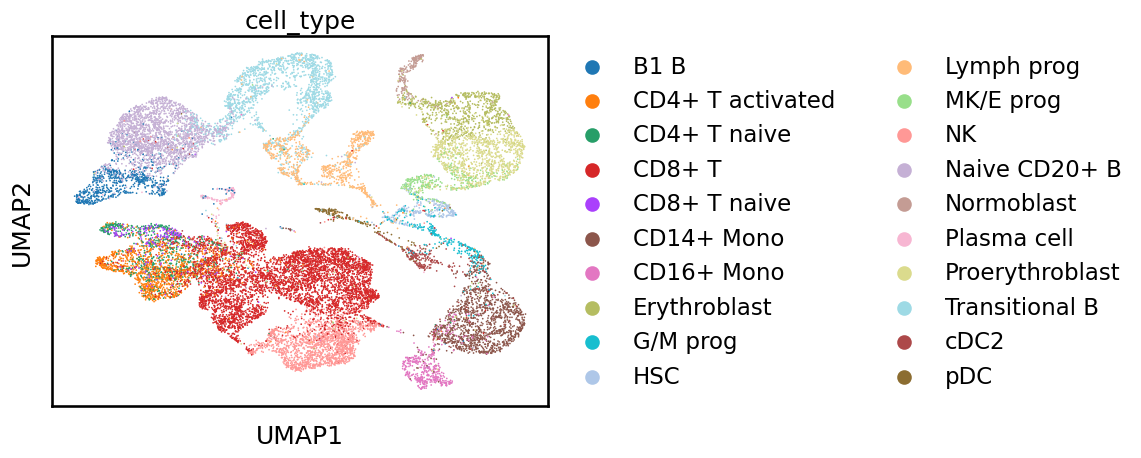

/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` instead.
  cmap = copy(get_cmap(cmap))
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


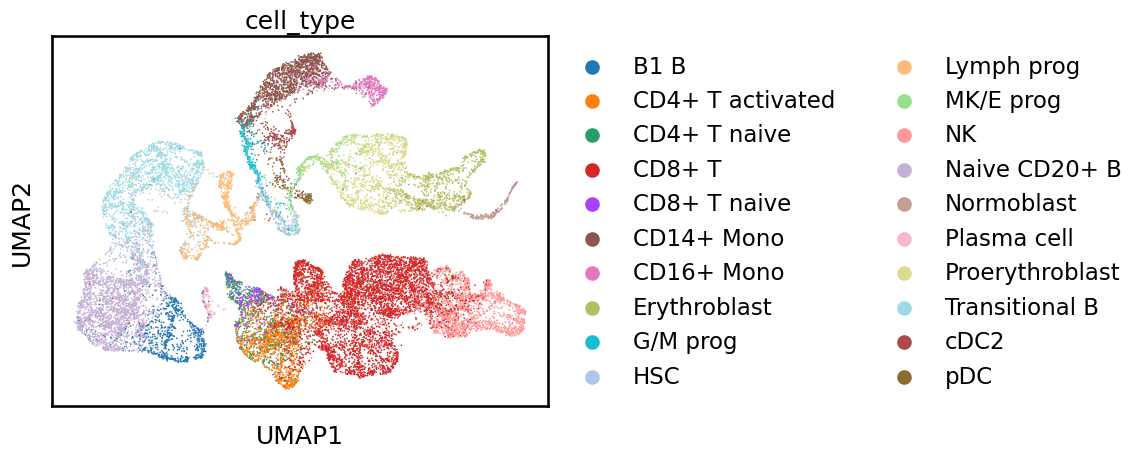

In [22]:
sc.pl.umap(ad_rna_imputed, color=['cell_type'])
sc.pl.umap(ad_atac_imputed, color=['cell_type'])

/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` instead.
  cmap = copy(get_cmap(cmap))
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


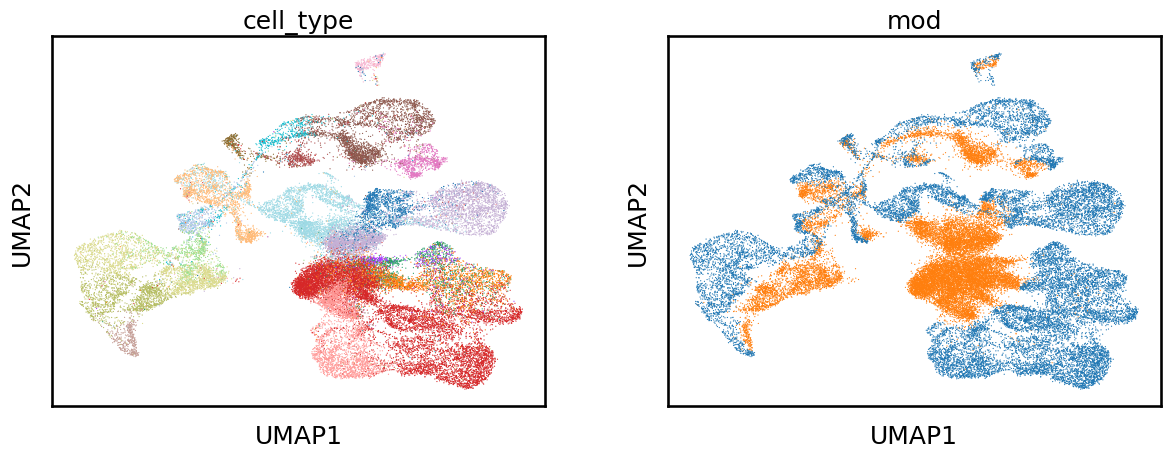

/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` instead.
  cmap = copy(get_cmap(cmap))
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


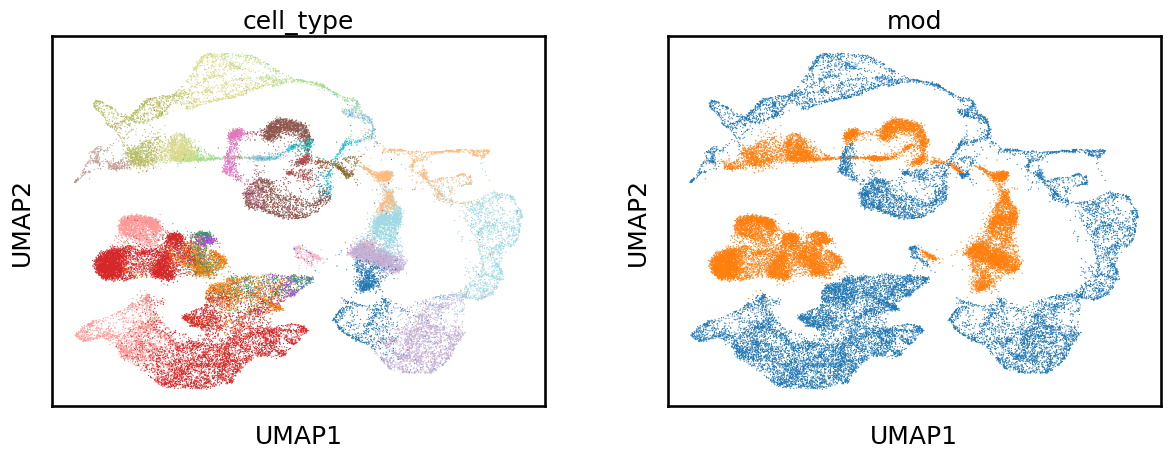

In [23]:
sc.pl.umap(ad_rna_concat, color=['cell_type', 'mod'], legend_loc=None)
sc.pl.umap(ad_atac_concat, color=['cell_type', 'mod'], legend_loc=None)